# My Titanic Project

## 0. Packages

In [1]:
# Handle table-like data and matrices calculation
import numpy as np
import scipy as sp
import pandas as pd


# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns


# Modelling Algorithms
# I will look at only four classification algorithms: LogisticRegression, GaussianNB, SVM, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier

# Modelling Helpers
from sklearn.preprocessing import Imputer , Normalizer , scale
# from sklearn.cross_validation import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# 1. Get to know our dataset

In [2]:
train_df=pd.read_csv('train.csv',sep=',')
test_df=pd.read_csv('test.csv')

## Concatnate these two dataframe:
full_df=pd.concat([train_df,test_df])

In [3]:
full_df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [4]:
print 'There are ',full_df.shape[1],' columns, and they are ',full_df.columns.values
print 'The total passengers are: ', full_df.shape[0]

There are  12  columns, and they are  ['Age' 'Cabin' 'Embarked' 'Fare' 'Name' 'Parch' 'PassengerId' 'Pclass'
 'Sex' 'SibSp' 'Survived' 'Ticket']
The total passengers are:  1309


Let's look at the missing values:

In [5]:
## This is a useful function:

def list_null(df):
    print df.shape[1],' columns:'
    for i in df.columns.values:
        print i,': nan',df[i].isnull().sum(),', ',df[i].dtypes
        
list_null(full_df)

12  columns:
Age : nan 263 ,  float64
Cabin : nan 1014 ,  object
Embarked : nan 2 ,  object
Fare : nan 1 ,  float64
Name : nan 0 ,  object
Parch : nan 0 ,  int64
PassengerId : nan 0 ,  int64
Pclass : nan 0 ,  int64
Sex : nan 0 ,  object
SibSp : nan 0 ,  int64
Survived : nan 418 ,  float64
Ticket : nan 0 ,  object


**Conclusion:**

There are too many missing values in Cabin, it should be save to remove this feature.
PassengerID is not really important, we can ignore it


## 2. Clean our dataset

### 2.1 Fill in missing value

In [89]:
## Age:
age=pd.DataFrame()
average_age   = full_df["Age"].mean()
std_age       = full_df["Age"].std()
count_nan_age = full_df["Age"].isnull().sum()
rand = np.random.randint(average_age - std_age, average_age + std_age, size = count_nan_age)
full_df['Age'][full_df.Age.isnull()] = rand
age['Age']=full_df['Age']

C:\Users\Tsymbal Group Member\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [93]:
age.head()

,Age
0,22.0
1,38.0
2,26.0
3,35.0
4,35.0


In [8]:
## Fare:
fare=pd.DataFrame()
fare=full_df['Fare'].fillna(full_df['Fare'].mean())

In [9]:
fare.head()

0     7.2500
1    71.2833
2     7.9250
3    53.1000
4     8.0500
Name: Fare, dtype: float64

In [13]:
## Embarked
embarked=pd.get_dummies(full_df['Embarked'],prefix='Embarked')
embarked.shape

(1309, 3)

In [53]:
## sex:
sex=pd.DataFrame()

sex['sex']=full_df['Sex']
sex['sex']=sex['sex'].apply(lambda x: 1 if x=='male' else 0)
sex.head()

,sex
0,1
1,0
2,0
3,0
4,1


In [54]:
sex.shape

(1309, 1)

### 2.2 Feature engineering

In [29]:
title = pd.DataFrame()
# we extract the title from each name
title[ 'Title' ] = full_df[ 'Name' ].map( lambda name: name.split( ',' )[1].split( '.' )[0].strip() )

# a map of more aggregated titles
Title_Dictionary = {
                    "Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Lady",
                    "Don":        "Sir",
                    "Sir" :       "Sir",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "the Countess":"Lady",
                    "Dona":       "Lady",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Master",
                    "Lady" :      "Lady"

                    }

# we map each title
title[ 'Title' ] = title.Title.map( Title_Dictionary )
title = pd.get_dummies( title.Title ).astype(int)
#title = pd.concat( [ title , titles_dummies ] , axis = 1 )

title.head()

,Lady,Master,Miss,Mr,Mrs,Officer,Sir
0,0,0,0,1,0,0,0
1,0,0,0,0,1,0,0
2,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0
4,0,0,0,1,0,0,0


In [25]:
## Sibsp and Parch

family=pd.DataFrame()

family['children']=full_df['Parch'].map(lambda x:1 if x>=1 else 0)
family['fmember']=full_df['SibSp'].map(lambda x:1 if x>0 else 0)

In [35]:
family.head()

,children,fmember
0,0,1
1,0,1
2,0,0
3,0,1
4,0,0


In [108]:
pclass=pd.DataFrame()
pclass['pclass']=full_df['Pclass']

#### New dataset:

In [97]:
survived=pd.DataFrame(full_df['Survived'])
survived.head()

,Survived
0,0.0
1,1.0
2,1.0
3,1.0
4,0.0


In [116]:
newdf = pd.concat( [age,fare,sex,survived,family,title,embarked,pclass] , axis=1 )
newdf.head()

,Age,Fare,sex,Survived,children,fmember,Lady,Master,Miss,Mr,Mrs,Officer,Sir,Embarked_C,Embarked_Q,Embarked_S,pclass
0,22.0,7.2500,1,0.0,0,1,0,0,0,1,0,0,0,0.0,0.0,1.0,3
1,38.0,71.2833,0,1.0,0,1,0,0,0,0,1,0,0,1.0,0.0,0.0,1
2,26.0,7.9250,0,1.0,0,0,0,0,1,0,0,0,0,0.0,0.0,1.0,3
3,35.0,53.1000,0,1.0,0,1,0,0,0,0,1,0,0,0.0,0.0,1.0,1
4,35.0,8.0500,1,0.0,0,0,0,0,0,1,0,0,0,0.0,0.0,1.0,3


### 2.3 Features importance

Let's look at the pictures that will let us know the importance

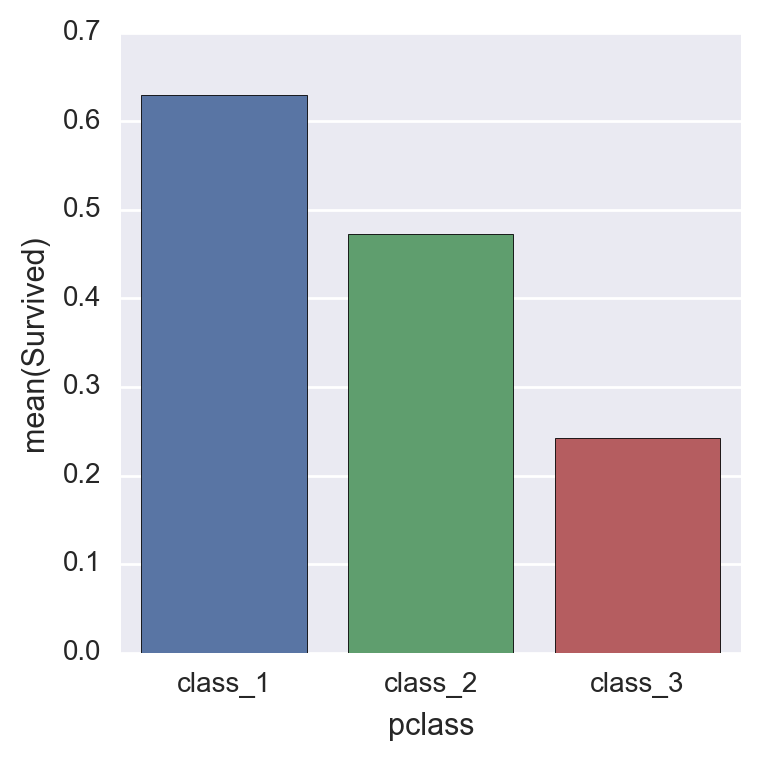

In [110]:
fig, axes = plt.subplots(1, 1, figsize=(4,4))


Pclass=newdf[["pclass", "Survived"]].groupby(['pclass'],as_index=False).mean()

sns.barplot(x='pclass',y='Survived',data=Pclass)
axes.set_xticklabels(('class_1', 'class_2','class_3'))

[<matplotlib.text.Text at 0xdbe7b90>, <matplotlib.text.Text at 0xdb7d390>]

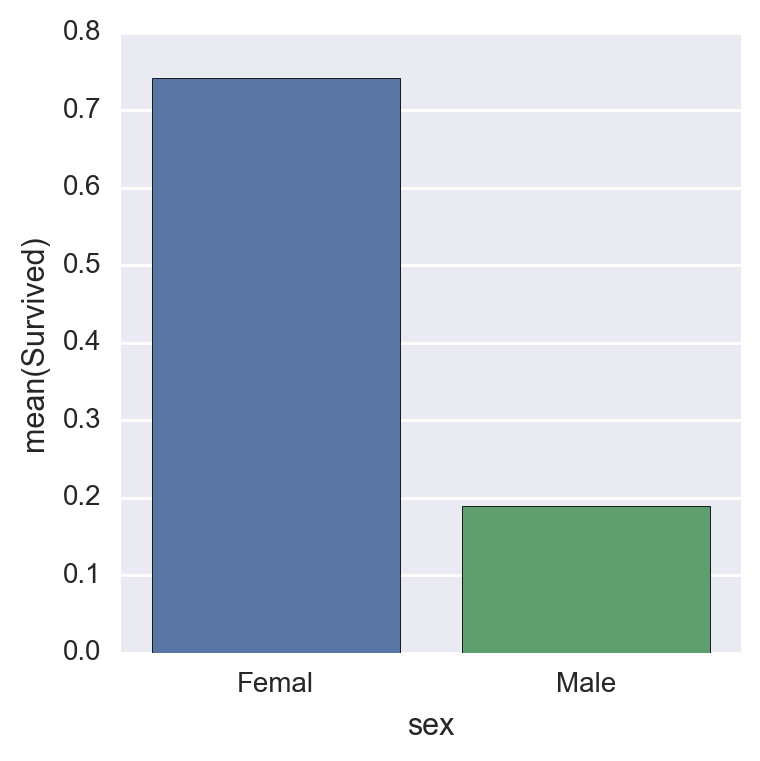

In [112]:
fig, axes = plt.subplots(1, 1, figsize=(4,4))


Sex=newdf[["sex", "Survived"]].groupby(['sex'],as_index=False).mean()

sns.barplot(x='sex',y='Survived',data=Sex)
axes.set_xticklabels(('Femal', 'Male'))

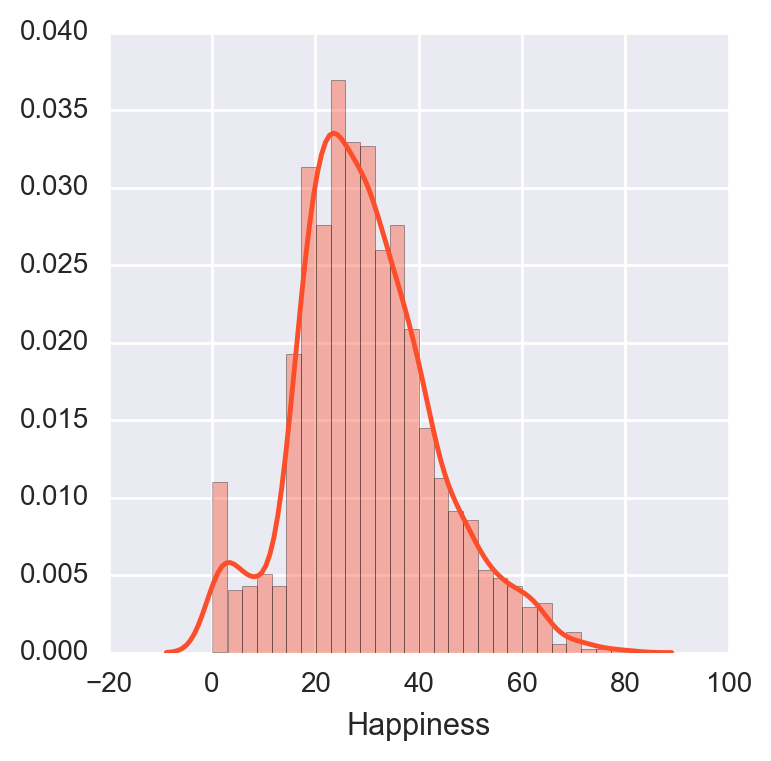

In [113]:
fig, axes = plt.subplots(1, 1, figsize=(4,4))

sns.distplot(newdf['Age'], kde=True, rug=False,fit=None, hist_kws=None,kde_kws=None,color='#fc4e2a', vertical=False, norm_hist=False, axlabel='Happiness', label=None, ax=None)

[<matplotlib.text.Text at 0xd510b30>, <matplotlib.text.Text at 0xd4f37d0>]

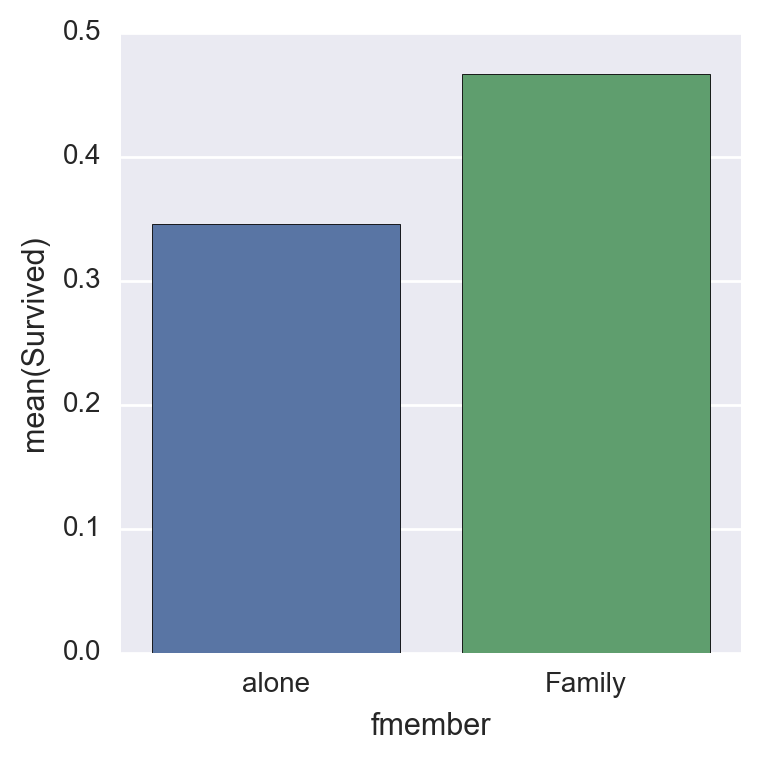

In [117]:
fig, axes = plt.subplots(1, 1, figsize=(4,4))


Family=newdf[["fmember", "Survived"]].groupby(['fmember'],as_index=False).mean()

sns.barplot(x='fmember',y='Survived',data=Family)
axes.set_xticklabels(('alone', 'Family'))

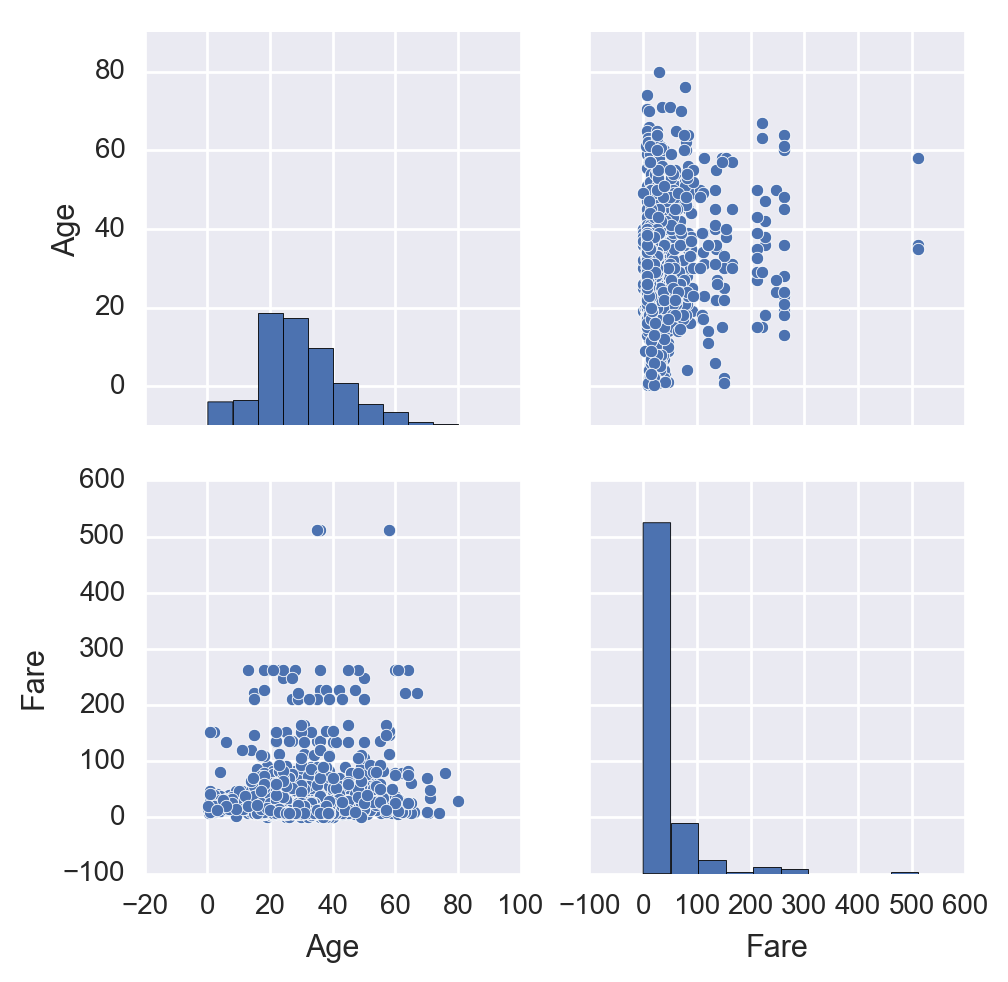

In [120]:
sns.pairplot(newdf[['Age','Fare']])

[<matplotlib.text.Text at 0x1160ce10>, <matplotlib.text.Text at 0x1167bc70>]

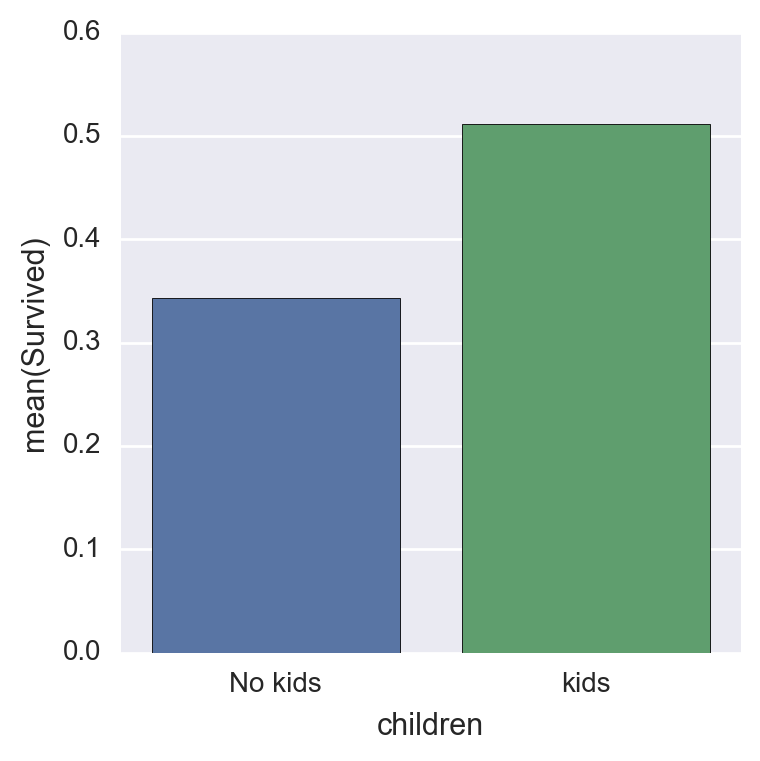

In [124]:
fig, axes = plt.subplots(1, 1, figsize=(4,4))


Child=newdf[["children", "Survived"]].groupby(['children'],as_index=False).mean()

sns.barplot(x='children',y='Survived',data=Child)
axes.set_xticklabels(('No kids', 'kids'))